In [100]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [2]:
def load_dataset(up_to= None):
    '''
    Charge les fichiers DVF jusqu'à une année donnée (incluse).

    Paramètres:
        up_to (str): Année maximale à charger, ex: "2020", "2023".

    Return:
        DataFrame Pandas combiné sans doublons.
    '''

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to is not None) and (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        if (up_to is not None) and (year == up_to):
            break

    data = pd.concat(data_list, ignore_index= True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")

    return data

In [3]:
def parse_dataset(dataset, min_price= 1_000, max_price= 2_000_000):
    '''
    Parsing des données, on ne garde que les lignes des ventes et de certains types de local.
    Seule les colonnes suivantes sont gardées : "Valeur fonciere", "Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales".
    Les lignes comportant des NaN sont supprimées.
    Ajout de colonnes pour "Année", "Mois", "Jour".
    Valeurs de target plafonnée.

    Paramètres:
        dataset (dataset): strucutre d'un fichier DVF.
        max_price (float): valeur maximum de target.

    Retour:
        dataFrames Pandas, X contenant les features et y contenant la target.
    '''

    if max_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price >= max_price:
        print("Erreur: \"min_price\" doit être < à \"max_price\"")
        return -1

    dataset = dataset[(dataset["Nature mutation"] == "Vente")]

    dataset = dataset.dropna(subset= ["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"])
    dataset["Valeur fonciere"] = dataset["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)
    dataset["Date mutation"] = pd.to_datetime(dataset["Date mutation"], format="%d/%m/%Y", errors="coerce")
    dataset["Annee"] = dataset["Date mutation"].dt.year
    dataset["Mois"] = dataset["Date mutation"].dt.month
    # dataset["Jour"] = dataset["Date mutation"].dt.day
    dataset["Surface reelle bati"] = dataset["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    dataset["Nombre pieces principales"] = dataset["Nombre pieces principales"].astype(int)
    dataset["Surface terrain"] = dataset["Surface terrain"].str.replace(",", ".", regex= False).astype(float)
    dataset["Prix au m2"] = dataset["Valeur fonciere"] / dataset["Surface reelle bati"]

    dataset = dataset[(dataset["Type local"] == "Maison") | (dataset["Type local"] == "Appartement")]
    dataset = dataset[(dataset["Valeur fonciere"] >= min_price) &
                (dataset["Valeur fonciere"] <= max_price) &
                (dataset["Surface reelle bati"] >= 15) &
                (dataset["Surface reelle bati"] <= 300) &
                (dataset["Surface terrain"] <= 10_00) &
                (dataset["Nombre pieces principales"] >= 1) &
                (dataset["Nombre pieces principales"] <= 12)
                # (dataset["Prix au m2"] >= 300) &
                # (dataset["Prix au m2"] <= 10_000)
                ]
    features = ["Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Annee", "Mois"]
    target = "Valeur fonciere"

    return dataset, features, target

In [4]:
def visualize_dataset(data, min_price= 10_000, max_price= 2_000_000):

    # dataset, features, target = parse_dataset(data, min_price= 0, max_price= 100_000_000)
    dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 2_000_000)
    X = dataset[features]
    print("Shape des features:", X.shape)
    print("Colonnes:", X.columns.tolist())
    print("\nAperçu des données:")
    display(X.head())
    print("\nRésumé statistique des variables numériques:")
    display(X.describe())
    print("\nRépartition des types de biens:")
    print(X["Type local"].value_counts())

    plt.figure(figsize= (20, 6))
    for type_local in dataset["Type local"].unique():
        subset = dataset[dataset["Type local"] == type_local]
        plt.scatter(subset["Date mutation"], subset["Valeur fonciere"], label= type_local, alpha= .2, s= 1)
    plt.title("Ventes à différentes dates")
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.xlabel("Date de vente")
    plt.ylabel("Valeur foncière (€)")
    plt.yscale("log")
    plt.grid(True, which= "both")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (10, 6))
    for type_local in dataset["Type local"].unique():
       subset = dataset[dataset["Type local"] == type_local]
       plt.hist(subset["Valeur fonciere"], label= type_local, alpha= .5, bins= 200, log= False, density= False)
    plt.hist(dataset["Valeur fonciere"], label= "Total", bins= 200, log= False, density= False, histtype= "step", color = 'k')
    plt.title("Distribution des valeurs foncière")
    plt.xlabel("Valeur foncière (€)")
    plt.ylabel("Nombre de ventes")
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.show()

    plt.figure(figsize= (10, 6))
    for type_local in dataset["Type local"].unique():
        subset = dataset[dataset["Type local"] == type_local]
        plt.scatter(subset["Surface reelle bati"], subset["Valeur fonciere"], label= type_local, alpha= .1, s= 1)
    plt.title("Valeur foncière en fonction de la surface du bâtiement")
    plt.xlabel("Surface réelle (m²)")
    plt.ylabel("Valeur foncière (€)")
    plt.grid(True)
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (20, 6))
    plt.scatter(dataset["Code departement"], dataset["Prix au m2"], s= 1)
    for departement in dataset["Code departement"].unique():
        subset = dataset[dataset["Code departement"] == departement]
        plt.errorbar(departement, np.mean(subset["Prix au m2"]), yerr= np.std(subset["Prix au m2"], ddof= 1), c= "k", capsize= 6)
    plt.title("Distribution du prix au m² par département")
    plt.xlabel("Code département")
    plt.ylabel("Prix au m² (€)")
    plt.xticks(rotation= 45)
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (10, 6))
    seaborn.heatmap(dataset.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matrice de corrélation des variables numériques")
    plt.tight_layout()
    plt.show()

    return

In [ ]:
data = load_dataset(up_to= "2021") #TODO crash toujour lorsque load au dessus de 2021

Chargement 2019...
Chargement 2020...

5,489,966 lignes chargées au total.


Shape des features: (957663, 7)
Colonnes: ['Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Annee', 'Mois']

Aperçu des données:


Code departement Type local  Surface terrain  Surface reelle bati  \
0               01     Maison            695.0                150.0   
1               01     Maison            888.0                 94.0   
2               01     Maison            500.0                 94.0   
3               01     Maison            522.0                 90.0   
6               01     Maison            557.0                110.0   

   Nombre pieces principales  Annee  Mois  
0                          5   2019     7  
1                          4   2019     7  
2                          4   2019     7  
3                          3   2019     7  
6                          5   2019     7


Résumé statistique des variables numériques:


Surface terrain  Surface reelle bati  Nombre pieces principales  \
count    957663.000000        957663.000000              957663.000000   
mean        442.599886            94.225054                   3.969462   
std         264.435442            41.455101                   1.497189   
min           0.000000            15.000000                   1.000000   
25%         215.000000            67.000000                   3.000000   
50%         435.000000            90.000000                   4.000000   
75%         623.000000           116.000000                   5.000000   
max        1000.000000           300.000000                  12.000000   

               Annee           Mois  
count  957663.000000  957663.000000  
mean     2019.641887       7.952400  
std         0.479446       3.185319  
min      2019.000000       1.000000  
25%      2019.000000       6.000000  
50%      2020.000000       9.000000  
75%      2020.000000      10.000000  
max      2020.000000      12.000000


Répartition des types de biens:
Type local
Maison         832835
Appartement    124828
Name: count, dtype: int64


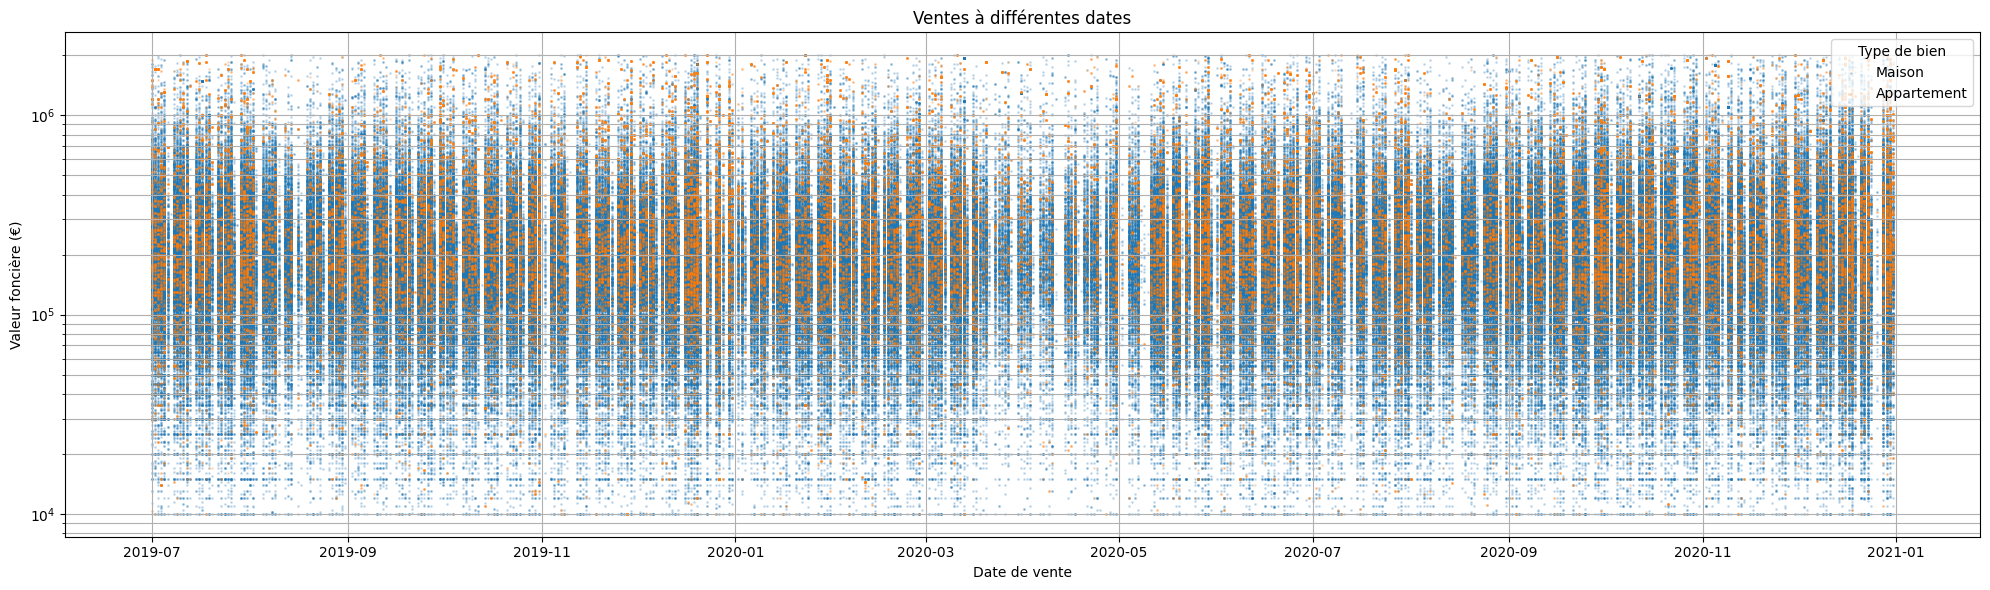

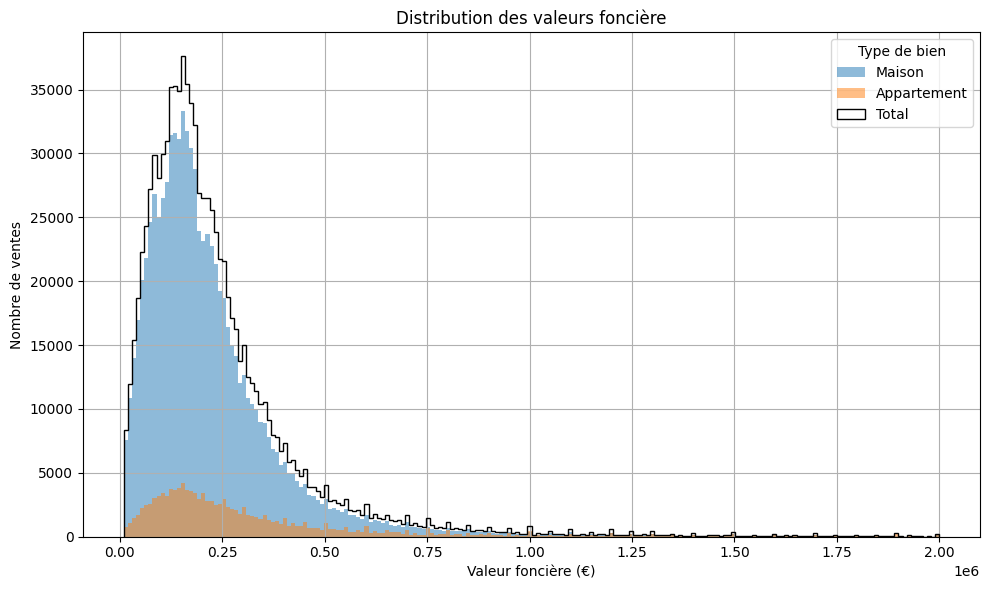

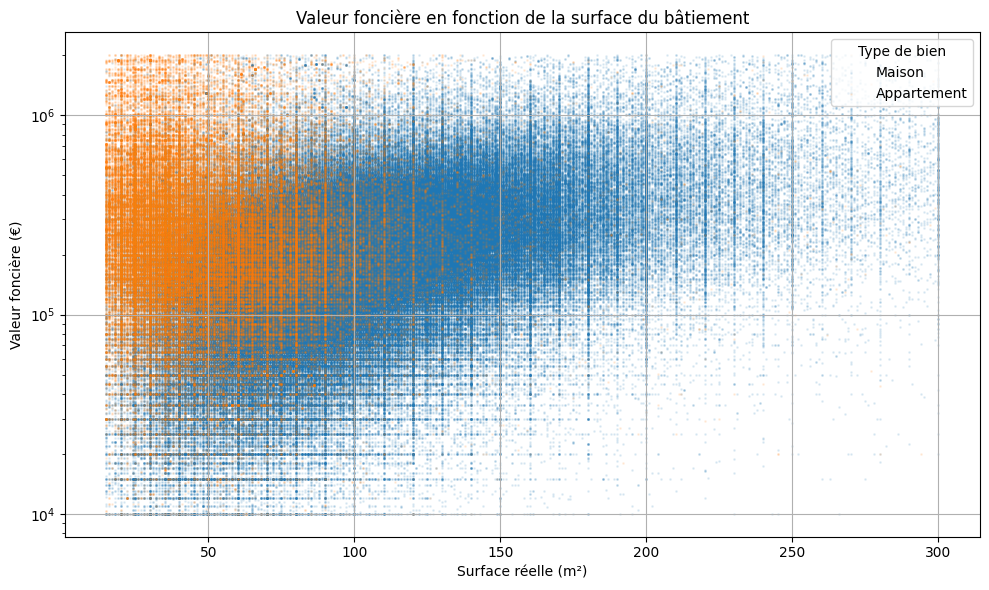

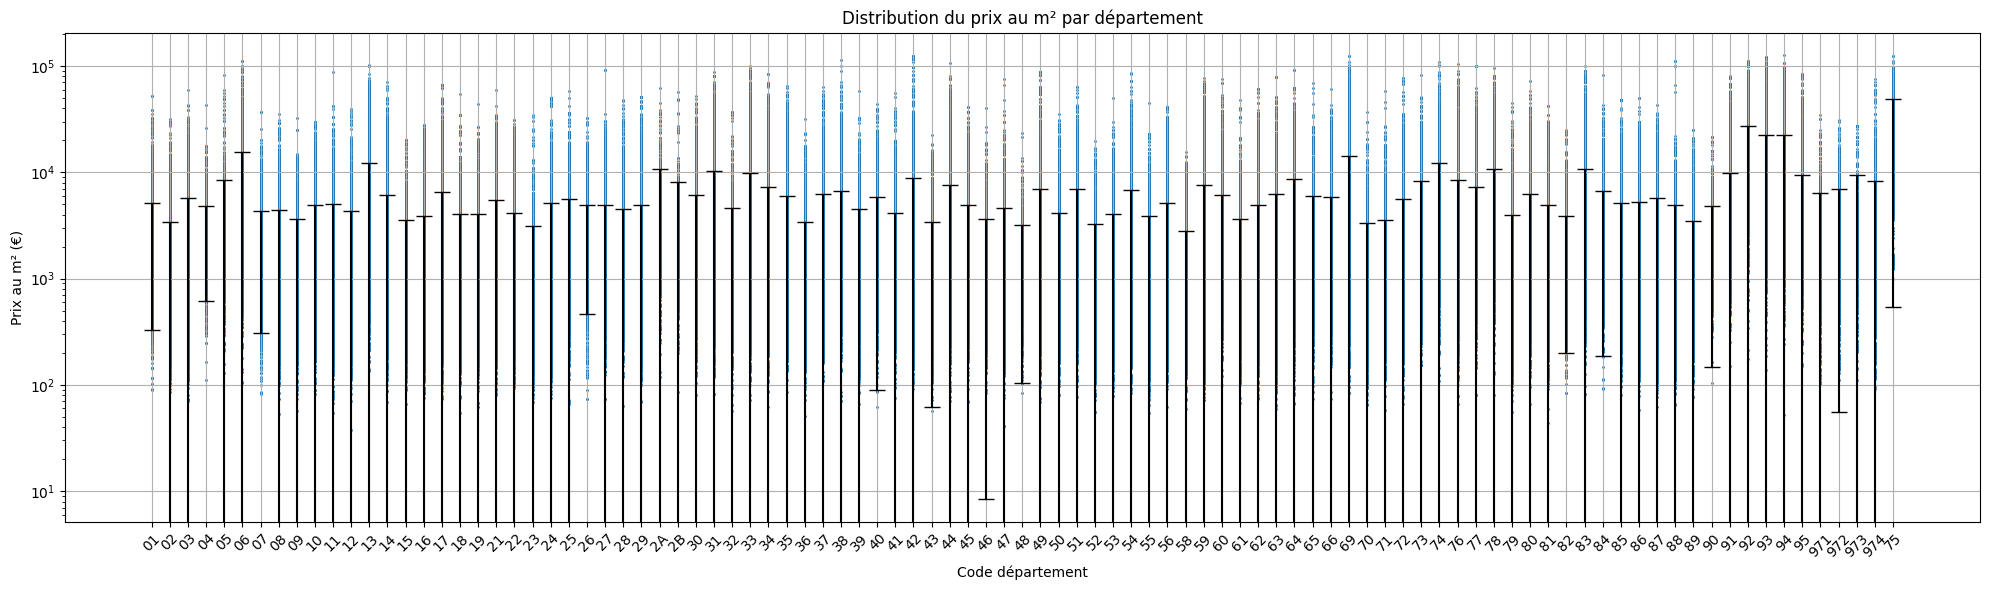

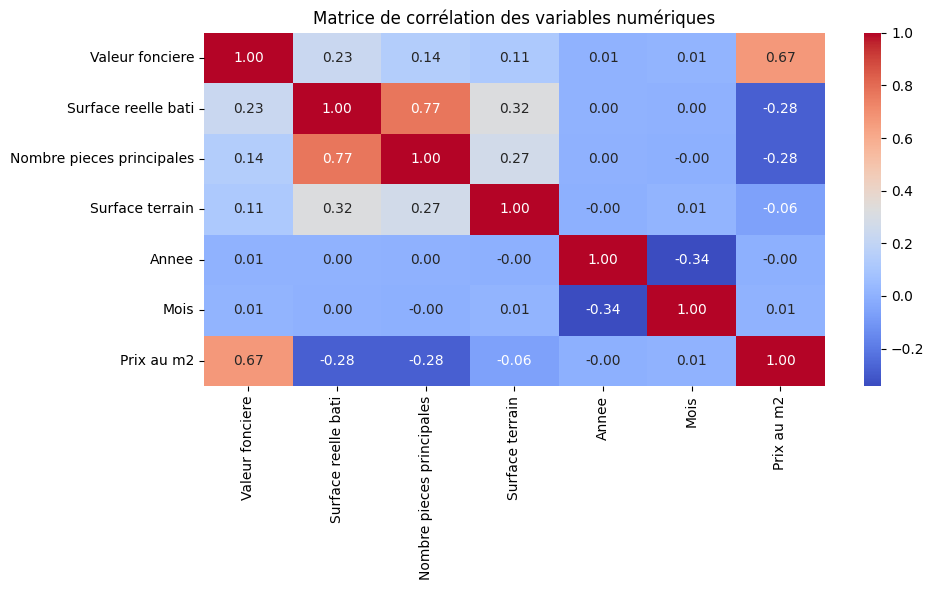

In [6]:
visualize_dataset(data, min_price= 10_000, max_price= 2_000_000)

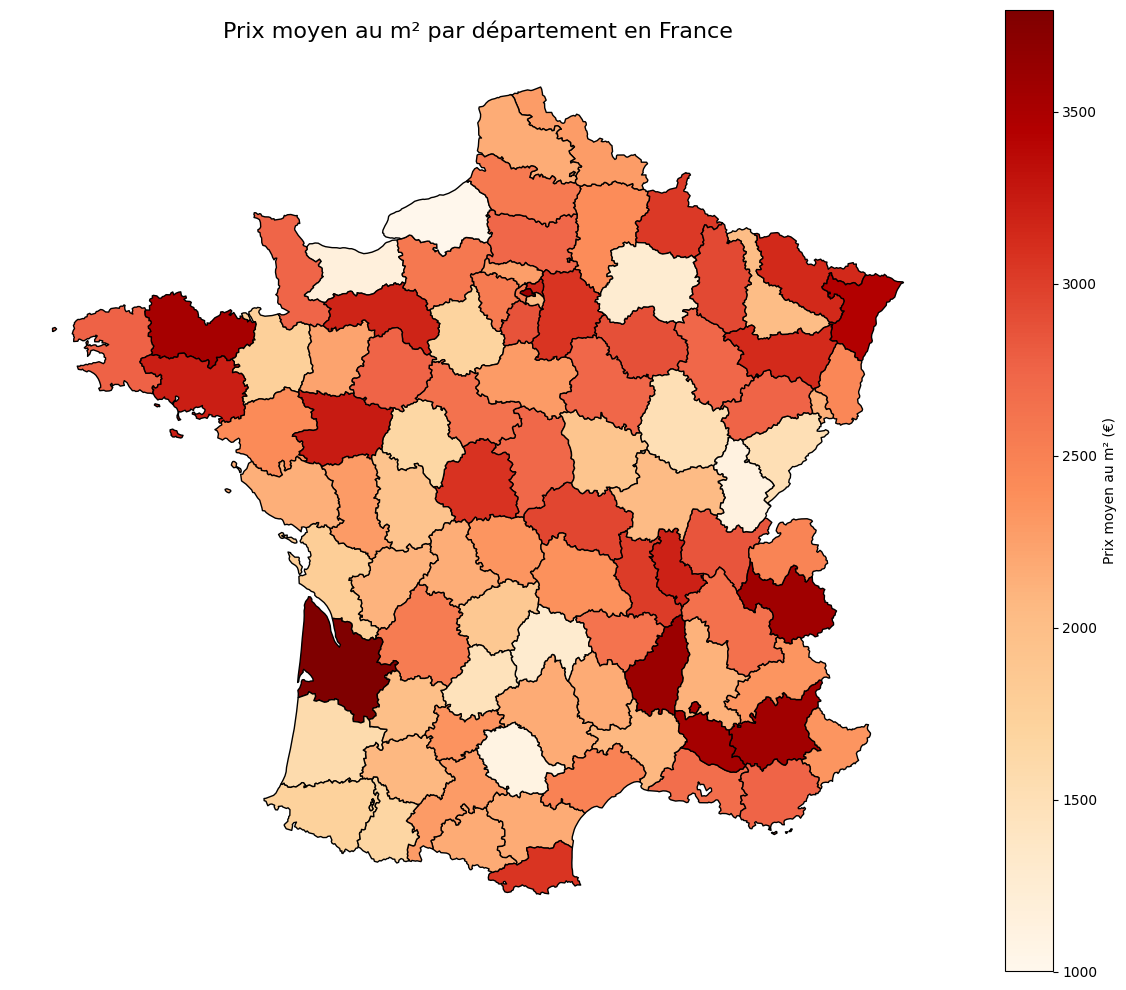

In [7]:
import geopandas as gpd

# Simuler les données de prix moyen au m² par département
np.random.seed(42)
departement_codes = [f"{i:02}" for i in range(1, 96) if i not in [20]]  # exclure 20 pour Corse
prix_moyen = np.random.normal(2500, 700, len(departement_codes)).clip(1000, 5000)
prix_par_dept = pd.DataFrame({
    "code_dept": departement_codes,
    "prix_m2_moyen": prix_moyen
})



# Lire un vrai fond de carte des départements français (utilisation d'une source alternative)
# Ici on charge un fichier GeoJSON connu via GeoPandas si disponible
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
try:
    gdf_dept = gpd.read_file(url)
    # Harmoniser le format de code
    gdf_dept["code"] = gdf_dept["code"]
    # Merge avec les données de prix
    gdf_merged = gdf_dept.merge(prix_par_dept, left_on="code", right_on="code_dept", how="left")

    # Tracer la carte
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    gdf_merged.plot(
        column="prix_m2_moyen",
        ax=ax,
        legend=True,
        cmap="OrRd",
        legend_kwds={"label": "Prix moyen au m² (€)"},
        edgecolor="black"
    )
    ax.set_title("Prix moyen au m² par département en France", fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Impossible de charger la carte des départements :", e)


# Random Forest

In [8]:
def process_features(X):
    '''
    Normalise et classifie X.

    Paramètres:
        X (Dataframe): DataFrame contenant les features.

    Retour:
        La DataFrame d'entrée avec ses valeurs processées.
    '''

    categorical_features = ["Code departement", "Type local"]
    numeric_features = ["Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Annee", "Mois"]
    preprocessor = ColumnTransformer(transformers= [(
        'num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown= 'ignore'), categorical_features)
        ])
    X_processed = preprocessor.fit_transform(X)

    return X_processed

def do_pca(X, n_components= 10):
    '''
    Reduction dimensionnelle par PCA de l'entrée.

    Paramètres:
        X (DataFrame): données d'entrée.
        n_components (int): nombre de composantes principales à conserver.

    Retour:
        Données transformées.
    '''

    X_processed = process_features(X)
    pca = PCA(n_components= n_components)
    X_pca = pca.fit_transform(X_processed)

    return X_pca

def plot_explained_variance(X, n_components= 10):
    '''
    Affiche la variance expliquée cumulée pour une PCA de n_components sur les données d'entrée.

    Paramètres:
        X (DataFrame): données d'entrée.
        n_components (int): nombre de composantes principales à conserver.

    Retour:
        None
    '''

    X_processed = process_features(X)
    pca = PCA(n_components= n_components)
    pca.fit(X_processed)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    n = np.arange(1, len(cumulative_variance) + 1)

    plt.figure(figsize= (10, 4))
    plt.plot(n, cumulative_variance, marker= "o", color= "r", ls= "--")
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Variance expliquée cumulée")
    plt.title("Variance expliquée cumulée par PCA")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

### Truncated dataset

In [127]:
dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 1_000_000)
X, y = dataset[features], dataset[target]

In [128]:
N = 100_000
X_sampled, y_sampled = X.sample(n= N, random_state= 42), y.sample(n= N, random_state= 42) #* Sous ensemble pour faire des test, même randome_state pour même indices
X_processed = process_features(X_sampled)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_sampled, test_size= .2)
y_train = np.log1p(y_train)

In [129]:
# r2_max = 0
# n_max, m_max = 0, 0
# for n in tqdm(range(10, 105, 5)):
#     for m in range(15, 105, 5):
#         model = RandomForestRegressor(n_estimators= n, max_depth= m, n_jobs= -1, random_state= 42)
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         y_pred = np.expm1(y_pred)
#         r2 = r2_score(y_test, y_pred)
#         if r2 > r2_max:
#             r2_max = r2
#             n_max, m_max = n, m

# print(f"n= {n_max}, m= {m_max}, R²= {r2_max:.2f}")

In [130]:
model = RandomForestRegressor(n_estimators= 35, max_depth= 55, n_jobs= -1, random_state= 42)

In [131]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1, random_state=42)

MAE : 81618.08 €
RMSE : 123933.43 €
R² : 0.3952


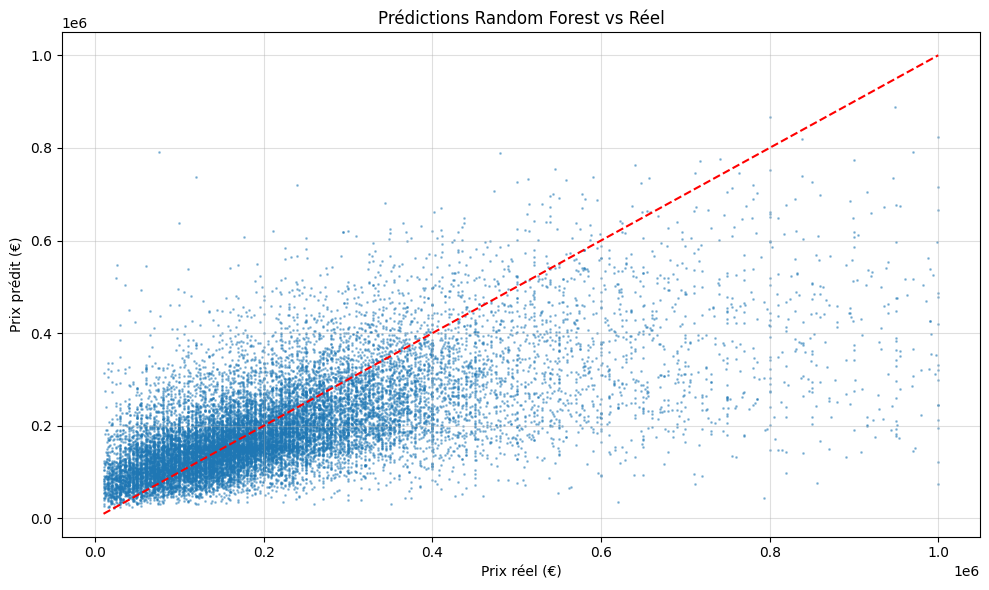

In [132]:
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.4f}")

plt.figure(figsize= (10, 6))
plt.scatter(y_test, y_pred, s= 1, alpha= .4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prix réel (€)")
plt.ylabel("Prix prédit (€)")
plt.title("Prédictions Random Forest vs Réel")
plt.grid(True, alpha= .4)
plt.tight_layout()
plt.show()

### Truncated with PCA

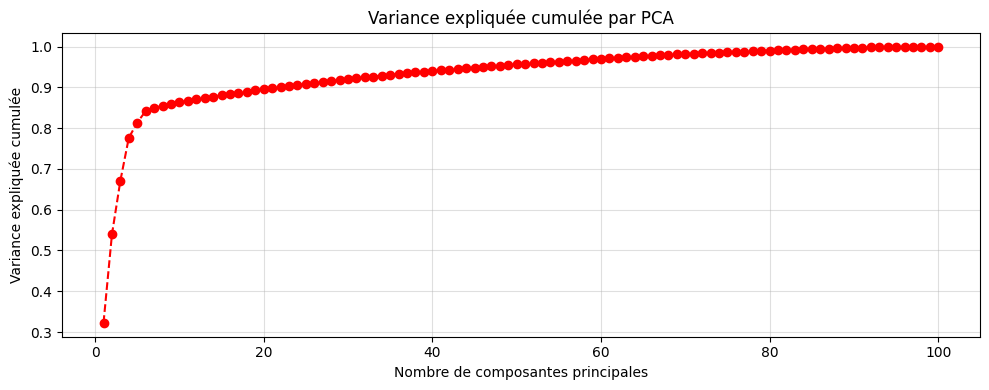

In [14]:
plot_explained_variance(X_sampled, 100)

In [155]:
X_pca = do_pca(X_sampled, n_components= 10)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_sampled, test_size= .2, random_state= 42)
y_train = np.log1p(y_train)

In [156]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1, random_state=42)

(100000, 10)


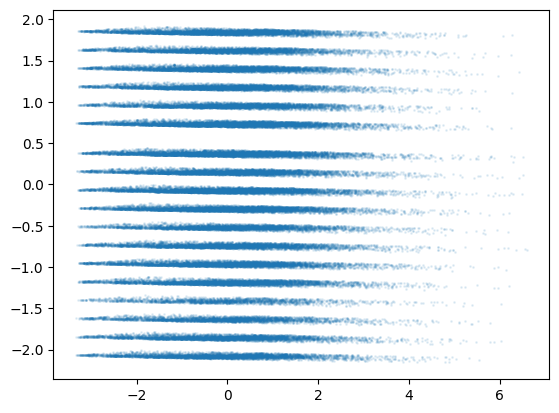

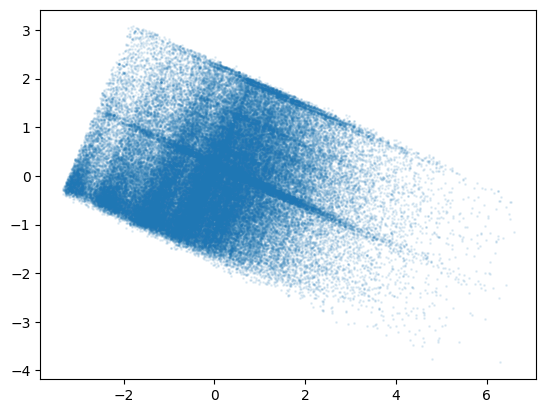

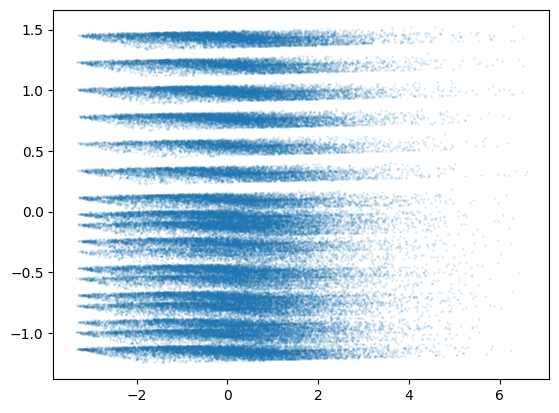

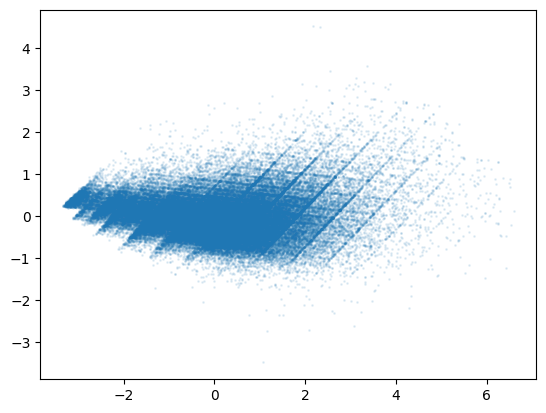

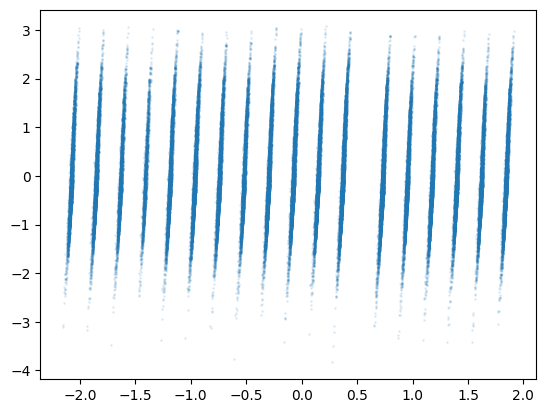

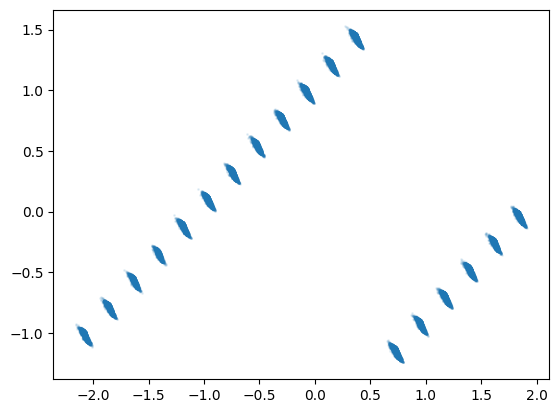

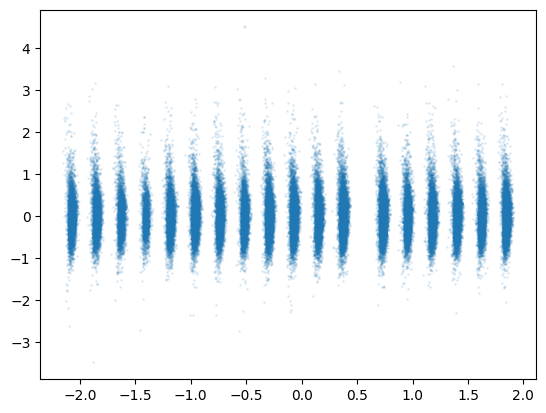

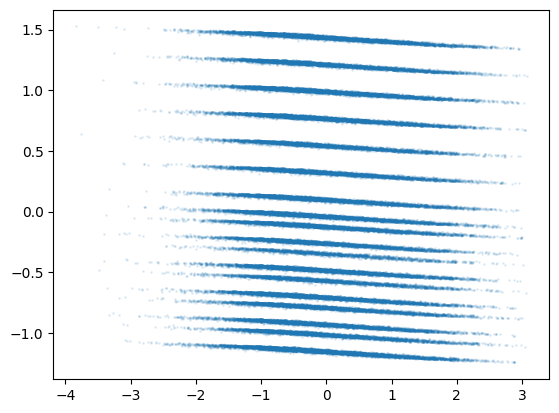

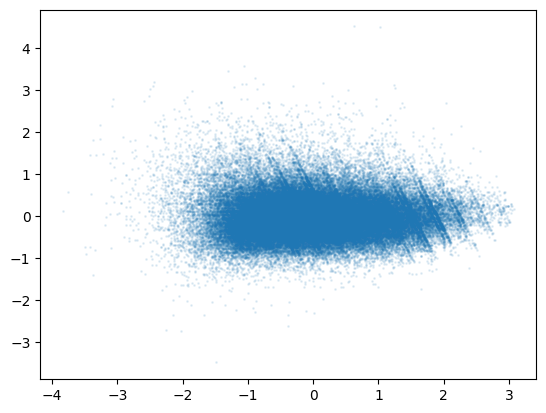

In [158]:
print(X_pca.shape)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], s= 1, alpha= .1)
plt.show()

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 2], s= 1, alpha= .1)
plt.show()

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 3], s= 1, alpha= .1)
plt.show()

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 4], s= 1, alpha= .1)
plt.show()


plt.figure()
plt.scatter(X_pca[:, 1], X_pca[:, 2], s= 1, alpha= .1)
plt.show()

plt.figure()
plt.scatter(X_pca[:, 1], X_pca[:, 3], s= 1, alpha= .1)
plt.show()

plt.figure()
plt.scatter(X_pca[:, 1], X_pca[:, 4], s= 1, alpha= .1)
plt.show()


plt.figure()
plt.scatter(X_pca[:, 2], X_pca[:, 3], s= 1, alpha= .1)
plt.show()

plt.figure()
plt.scatter(X_pca[:, 2], X_pca[:, 4], s= 1, alpha= .1)
plt.show()

MAE : 86830.63 €
RMSE : 134663.96 €
R² : 0.2912


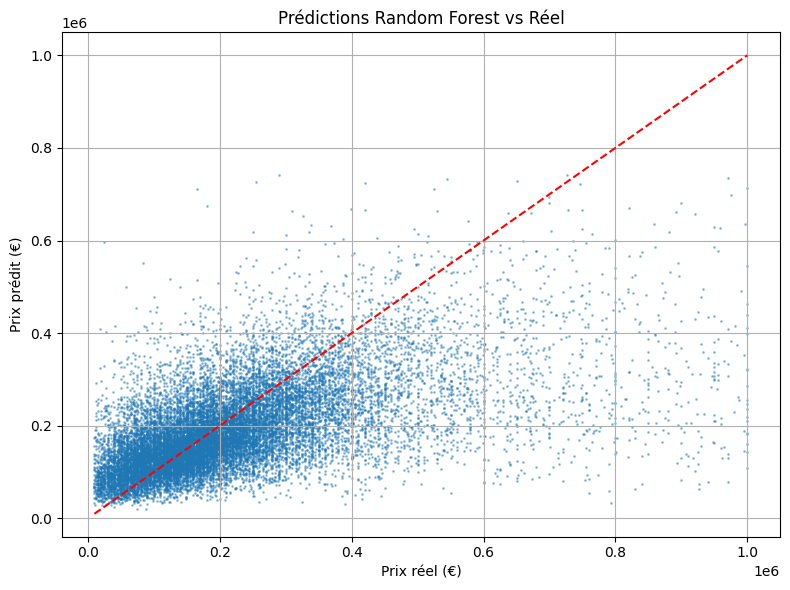

In [153]:
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha= .4, s= 1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prix réel (€)")
plt.ylabel("Prix prédit (€)")
plt.title("Prédictions Random Forest vs Réel")
plt.grid(True)
plt.tight_layout()
plt.show()

### Full dataset

In [159]:
X_train, X_test, y_train, y_test = train_test_split(process_features(X), y, test_size= .2, random_state= 42)
y_train = np.log1p(y_train)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1, random_state=42)

MAE : 76935.94 €
RMSE : 116959.91 €
R² : 0.4658


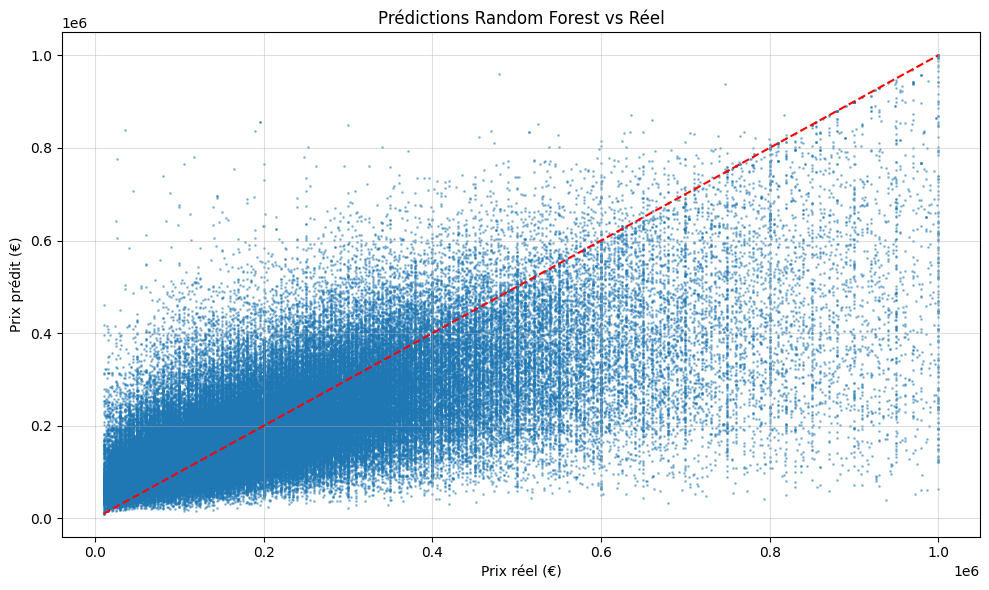

In [160]:
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.4f}")

plt.figure(figsize= (10, 6))
plt.scatter(y_test, y_pred, alpha= .4, s= 1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prix réel (€)")
plt.ylabel("Prix prédit (€)")
plt.title("Prédictions Random Forest vs Réel")
plt.grid(True, alpha= .4)
plt.tight_layout()
plt.show()

### Full with PCA

In [161]:
X_pca = do_pca(X, n_components= 10)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size= .2, random_state= 42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1, random_state=42)

MAE : 88970.44 €
RMSE : 129312.83 €
R² : 0.3470


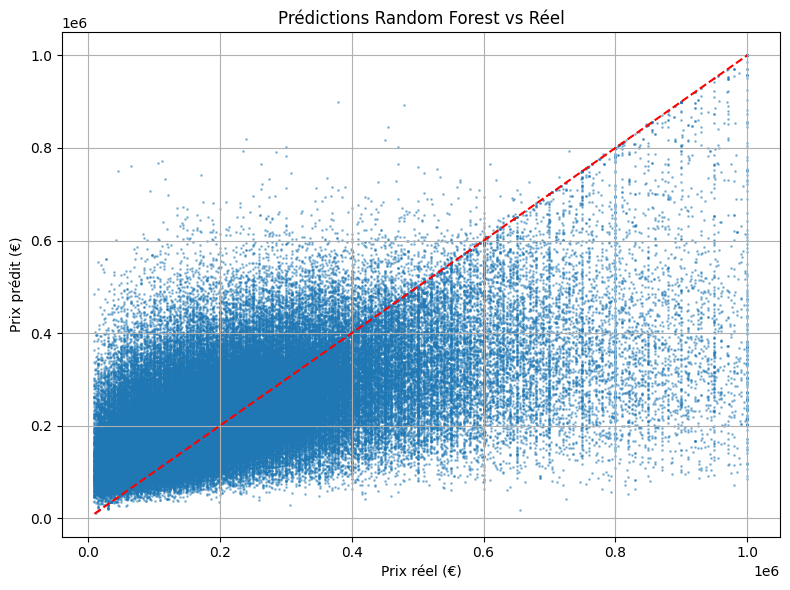

In [162]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha= .4, s= 1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prix réel (€)")
plt.ylabel("Prix prédit (€)")
plt.title("Prédictions Random Forest vs Réel")
plt.grid(True)
plt.tight_layout()
plt.show()